# Importing libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F


Working with CUDA capabilities.

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
1
0
GeForce RTX 2080 with Max-Q Design


# Loading the train data set

In [3]:
data_dir = '../../Images/june5Night/Positive/'      #This is for the home laptop
# data_dir = '../../../../BottleStoodUp_atNight/Positive/'        #For the work laptop

In [4]:
transform_characteristics = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize(255),
                                                transforms.CenterCrop(224)])
dataset = datasets.ImageFolder(data_dir, transform=transform_characteristics)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=15, shuffle=True)

We see 20 batches of 15 images each. Becasue we have in total 295 of positive images.

In [5]:
print(len(dataloader))

20


In [6]:
images, labels = next(iter(dataloader))
print("The images are stored in a variable of type: ", type(images))
print("The classes labels are: ", labels)
print(torch.min(images), torch.max(images))

c:\Users\alexj\.conda\envs\tfm_3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


The images are stored in a variable of type:  <class 'torch.Tensor'>
The classes labels are:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor(0.0004) tensor(1.)


# Showing one sample of the training set images

Grabbing only one image of the training set, permuting its shape sizes and converting to numpy to able to display it.

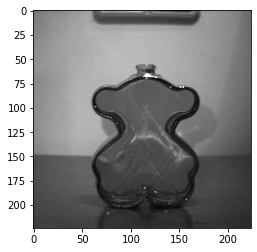

In [7]:
single_img = images[0]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.detach().numpy()

plt.imshow(single_img_numpy)

Now, cropping the image to be of size 160x160.

In [8]:
TOP_CROP_POS = 50
LEFT_CROP_POS = 35

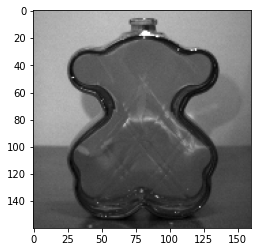

In [9]:


imgs_croped = transforms.functional.crop(images, TOP_CROP_POS, LEFT_CROP_POS, 160, 160)
single_img = imgs_croped[0]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.cpu().detach().numpy()

plt.imshow(single_img_numpy)

# Building the model Autoencoder model

In [10]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # 15, 3, 160, 160.  Batch size, input channels, shape of the image.
        input_channels = 3              # number of channels of the input image
        output_channels = 55           # ~= 110/2. Shape of the input image divided by 2 approximately. 
        kernel_size = 9
        padding_val = 1
        stride_val = 5

        output_channels_layer2 = output_channels*2+5
        output_channels_layer3 = output_channels_layer2*2
        
        self.conv2d_1 = nn.Conv2d(input_channels, output_channels, kernel_size, stride=stride_val, padding=padding_val)
        self.conv2d_2 = nn.Conv2d(output_channels, output_channels_layer2, kernel_size, stride=stride_val, padding=padding_val)
        self.conv2d_3 = nn.Conv2d(output_channels_layer2, output_channels_layer3, 5)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()

        self.fc = nn.Linear(output_channels_layer3, output_channels_layer3)
        self.encoder_tanh = nn.Tanh()
        self.decoder_tanh = nn.Tanh()
        self.decoder_fc = nn.Linear(output_channels_layer3, output_channels_layer3)

        self.convTranspose2d_1 = nn.ConvTranspose2d(output_channels_layer3, output_channels_layer2, 5)
        self.convTranspose2d_2 = nn.ConvTranspose2d(output_channels_layer2, output_channels, kernel_size, stride=stride_val, padding=padding_val, output_padding=4)
        self.convTranspose2d_3 = nn.ConvTranspose2d(output_channels, input_channels, kernel_size, stride=stride_val, padding=padding_val, output_padding=3)
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, flag = False):
        if flag:
            print("The FORWARD function is starting")

            print("The ENCODER part is executing")
            output = x
            print("The input image shape is: ", output.shape)
            output = self.conv2d_1(output)
            print("self.conv2d_1 shape is: ", output.shape)
            output = self.relu1(output)
            output = self.conv2d_2(output)
            print("self.conv2d_2 shape is: ", output.shape)
            output = self.relu2(output)
            output = self.conv2d_3(output)
            print("self.conv2d_3 shape is: ", output.shape)

            print("The LINEAR and TANH layers")
            output = output.view(output.size(0), -1)
            print("output.view shape is: ", output.shape)
            output = self.fc(output)
            print("self.fc shape is: ", output.shape)
            output = self.encoder_tanh(output)
            print("self.encoder_tanh shape is: ", output.shape)

            output = self.decoder_tanh(output)
            print("self.decoder_tanh shape is: ", output.shape)
            output = self.decoder_fc(output)
            print("self.decoder_fc shape is: ", output.shape)
            output = output.view(-1, output.size(1), 1, 1)
            print("output.view shape is: ", output.shape)
            

            print("The DECODER part is executing")
            output = self.convTranspose2d_1(output)
            print("self.convTranspose2d_1 shape is: ", output.shape)
            output = self.relu3(output)
            output = self.convTranspose2d_2(output)
            print("self.convTranspose2d_2 shape is: ", output.shape)
            output = self.relu4(output)
            output = self.convTranspose2d_3(output)
            print("self.convTranspose2d_3 shape is: ", output.shape)
            output = self.sigmoid(output)
            print("self.sigmoid shape is: ", output.shape)

            print("Finish the FORWARD function")
        else:
             # print("The FORWARD function is starting")

            # print("The ENCODER part is executing")
            output = x
            # print("The input image shape is: ", output.shape)
            output = self.conv2d_1(output)
            # print("self.conv2d_1 shape is: ", output.shape)
            output = self.relu1(output)
            output = self.conv2d_2(output)
            # print("self.conv2d_2 shape is: ", output.shape)
            output = self.relu2(output)
            output = self.conv2d_3(output)
            # print("self.conv2d_3 shape is: ", output.shape)

            # print("The LINEAR and TANH layers")
            output = output.view(output.size(0), -1)
            # print("output.view shape is: ", output.shape)
            output = self.fc(output)
            # print("self.fc shape is: ", output.shape)
            output = self.encoder_tanh(output)
            # print("self.encoder_tanh shape is: ", output.shape)

            output = self.decoder_tanh(output)
            # print("self.decoder_tanh shape is: ", output.shape)
            output = self.decoder_fc(output)
            # print("self.decoder_fc shape is: ", output.shape)
            output = output.view(-1, output.size(1), 1, 1)
            # print("output.view shape is: ", output.shape)
            

            # print("The DECODER part is executing")
            output = self.convTranspose2d_1(output)
            # print("self.convTranspose2d_1 shape is: ", output.shape)
            output = self.relu3(output)
            output = self.convTranspose2d_2(output)
            # print("self.convTranspose2d_2 shape is: ", output.shape)
            output = self.relu4(output)
            output = self.convTranspose2d_3(output)
            # print("self.convTranspose2d_3 shape is: ", output.shape)
            output = self.sigmoid(output)
            # print("self.sigmoid shape is: ", output.shape)

            # print("Finish the FORWARD function")
        return output
    
    def show_one_layer_weights(self, index):
        print("This is the one layer show function")
        i = 0
        for name, m in self.named_modules():
        # for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
                if i == index:
                    print("Layer name is:", name)
                    print("The weights are: ", m.weight)
                i = i +1   
 
# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

Making sure to use the GPU for the trainig stage

In [11]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)

cuda:0


In [12]:
model = Autoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-4, 
                             weight_decay=1e-5)
model.to(device)

Autoencoder(
  (conv2d_1): Conv2d(3, 55, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
  (conv2d_2): Conv2d(55, 115, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
  (conv2d_3): Conv2d(115, 230, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (relu2): ReLU()
  (fc): Linear(in_features=230, out_features=230, bias=True)
  (encoder_tanh): Tanh()
  (decoder_tanh): Tanh()
  (decoder_fc): Linear(in_features=230, out_features=230, bias=True)
  (convTranspose2d_1): ConvTranspose2d(230, 115, kernel_size=(5, 5), stride=(1, 1))
  (convTranspose2d_2): ConvTranspose2d(115, 55, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(4, 4))
  (convTranspose2d_3): ConvTranspose2d(55, 3, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(3, 3))
  (relu3): ReLU()
  (relu4): ReLU()
  (sigmoid): Sigmoid()
)

In [13]:
torch.cuda.empty_cache()

# Training the model

In [14]:
val_dir_for_training = '../../Images/june5Night/Positive_val'      #This is for the home laptop

transform_characteristics = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize(255),
                                                transforms.CenterCrop(224)])

dataset_val_for_training = datasets.ImageFolder(val_dir_for_training, transform=transform_characteristics)
dataloader_val_for_training = torch.utils.data.DataLoader(dataset_val_for_training, batch_size=15, shuffle=True)
print(len(dataloader_val_for_training))

2


Actually training the model with early stopping and storing the loss function values accross all epochs.

In [15]:
# epochs_toCheck_earlyStopping = 10
# min_diff_earlyStopping = 0.0005
# # Point to training loop video
# num_epochs = 300
# outputs = []
# prev_losses = [float('inf')] * epochs_toCheck_earlyStopping  # Initialize previous losses with infinity
# losses_list = []
# losses_avg_list = []

# losses_val_list = []
# losses_val_avg_list = []

# for epoch in range(num_epochs):
#     for (img, _) in dataloader:     # This iterates over the batches of images.
#         img = img.to(device)
#         # Forward pass
#         recon = model(img)          # The entire batch of images is passed to the model
#         loss = criterion(recon, img)

#         # Backward and optimize
#         optimizer.zero_grad()       # Sets the gradients of all optimized torch.Tensors to zero
#         loss.backward()             # The accumulation (or sum) of all the gradients is calculated     
#         optimizer.step()            # can be called once the gradients are computed 
#         losses_list.append(loss.item())  

#     for (img, _) in dataloader_val_for_training:     # This iterates over the batches of images.
#         img = img.to(device)
#         # Forward pass
#         recon_val = model(img.cuda())          # The entire batch of images is passed to the model
#         losses_val = criterion(recon_val, img)
#         losses_val_list.append(losses_val.item())

#     loss_avg_epoch = np.mean(losses_list[-len(dataloader):])
#     losses_avg_list.append(loss_avg_epoch)
    
#     loss_val_avg_epoch = np.mean(losses_val_list[-len(dataloader_val_for_training):])
#     losses_val_avg_list.append(loss_val_avg_epoch)

#     print(f'Epoch:{epoch+1}, average training loss:{loss_avg_epoch:.4f}, average validation loss:{loss_val_avg_epoch:.4f}')

#     # Append the current validation loss to the previous losses list
#     prev_losses.append(loss_val_avg_epoch)
#     prev_losses = prev_losses[-epochs_toCheck_earlyStopping:]  # Keep only the last 10 losses
#     # print(prev_losses)
#     # Check if the last 10 losses are the same (within a tolerance)
#     stop_training = all(abs(loss_val_avg_epoch - prev_loss) < min_diff_earlyStopping for prev_loss in prev_losses)

#     # Break the training loop if the stopping condition is met
#     if stop_training:
#         print('Early stopping triggered. Training stopped.')
#         break

# # open file
# with open('losseslistTrain.txt', 'w+') as g:
#     # write elements of list
#     for items in losses_list:
#         g.write('%s\n' %items)
#     print("losseslistTrain written successfully")
# # close the file
# g.close() 

# # open file
# with open('losseslist_avg_Train.txt', 'w+') as g:
#     # write elements of list
#     for items in losses_avg_list:
#         g.write('%s\n' %items)
#     print("losseslist_avg_Train written successfully")
# # close the file
# g.close()

# # open file
# with open('losseslistVal.txt', 'w+') as g:
#     # write elements of list
#     for items in losses_val_list:
#         g.write('%s\n' %items)
#     print("losseslistVal written successfully")
# # close the file
# g.close() 

# # open file
# with open('losses_avg_Val.txt', 'w+') as g:
#     # write elements of list
#     for items in losses_val_avg_list:
#         g.write('%s\n' %items)
#     print("losseslist_avg_Val written successfully")
# # close the file
# g.close()

In [16]:
filepath = "models/PytorchCUDA_AutoencoderDS2_croppingImages_V4"

Saving the model

In [17]:
# torch.save(model.state_dict(), filepath)

Loading the model

In [18]:
# For loading the model 
model.load_state_dict(torch.load(filepath))                                         # For home laptop
# model.load_state_dict(torch.load(filepath, map_location=torch.device('cpu')))     # For work laptop
model.eval()

Autoencoder(
  (conv2d_1): Conv2d(3, 55, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
  (conv2d_2): Conv2d(55, 115, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
  (conv2d_3): Conv2d(115, 230, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (relu2): ReLU()
  (fc): Linear(in_features=230, out_features=230, bias=True)
  (encoder_tanh): Tanh()
  (decoder_tanh): Tanh()
  (decoder_fc): Linear(in_features=230, out_features=230, bias=True)
  (convTranspose2d_1): ConvTranspose2d(230, 115, kernel_size=(5, 5), stride=(1, 1))
  (convTranspose2d_2): ConvTranspose2d(115, 55, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(4, 4))
  (convTranspose2d_3): ConvTranspose2d(55, 3, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(3, 3))
  (relu3): ReLU()
  (relu4): ReLU()
  (sigmoid): Sigmoid()
)

The evolution of the loss function accross all epochs.

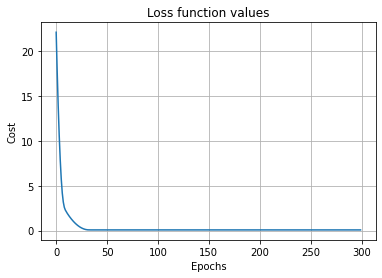

In [19]:
# Load data from the text file
with open("txtFilesAutoencoder_V4/losseslist_avg_Train_v3.txt", "r") as file:
    data = [float(line.strip()) for line in file]

# Plot the data
plt.plot(data)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Loss function values")
plt.grid(True)
plt.show()

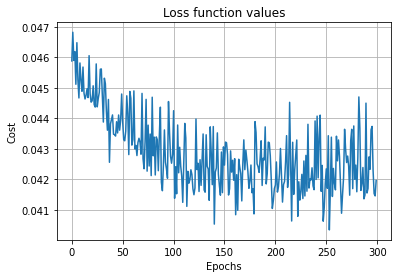

In [20]:
# Load data from the text file
with open("txtFilesAutoencoder_V4/losses_avg_Val_V3.txt", "r") as file:
    data = [float(line.strip()) for line in file]

# Plot the data
plt.plot(data)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Loss function values")
plt.grid(True)
plt.show()

Once the model has been trained we will show the results:

The below function is used for formatting the image to make it able to be showed.

In [21]:
#Utility functions to un-normalize and display an image
def imshow(img):
    # img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 

## Updating the weights of the Encoder part

In [22]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()        
         # 15, 3, 160, 160.  Batch size, input channels, shape of the image.
        input_channels = 3              # number of channels of the input image
        output_channels = 55           # ~= 110/2. Shape of the input image divided by 2 approximately. 
        kernel_size = 9
        padding_val = 1
        stride_val = 5

        
        output_channels_layer2 = output_channels*2+5
        output_channels_layer3 = output_channels_layer2*2
        
        self.conv2d_1 = nn.Conv2d(input_channels, output_channels, kernel_size, stride=stride_val, padding=padding_val)
        self.conv2d_2 = nn.Conv2d(output_channels, output_channels_layer2, kernel_size, stride=stride_val, padding=padding_val)
        self.conv2d_3 = nn.Conv2d(output_channels_layer2, output_channels_layer3, 5)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()

        self.fc = nn.Linear(output_channels_layer3, output_channels_layer3)

    def forward(self, x, flag = False):
        if flag:
            print("The FORWARD function is starting")

            print("The ENCODER part is executing")
            output = x
            print("The input image shape is: ", output.shape)
            output = self.conv2d_1(output)
            print("self.conv2d_1 shape is: ", output.shape)
            output = self.relu1(output)
            output = self.conv2d_2(output)
            print("self.conv2d_2 shape is: ", output.shape)
            output = self.relu2(output)
            output = self.conv2d_3(output)
            print("self.conv2d_3 shape is: ", output.shape)

            # print("The LINEAR and TANH layers")
            output = output.view(output.size(0), -1)
            print("output.view shape is: ", output.shape)
            output = self.fc(output)
            print("self.fc shape is: ", output.shape)
            print("Finish the FORWARD function")

        else:
            # print("The FORWARD function is starting")

            # print("The ENCODER part is executing")
            output = x
            # print("The input image shape is: ", output.shape)
            output = self.conv2d_1(output)
            # print("self.conv2d_1 shape is: ", output.shape)
            output = self.relu1(output)
            output = self.conv2d_2(output)
            # print("self.conv2d_2 shape is: ", output.shape)
            output = self.relu2(output)
            output = self.conv2d_3(output)
            # print("self.conv2d_3 shape is: ", output.shape)

            # print("The LINEAR and TANH layers")
            output = output.view(output.size(0), -1)
            # print("output.view shape is: ", output.shape)
            output = self.fc(output)
            # print("self.fc shape is: ", output.shape)

        return output
    
    def show_modules(self):
        print("This is the show modules function")
        i = 0
        for m in self.modules():
            print(m)
            print("i is: ", i)
            print("print the next module")
            i = i +1
            
    def show_one_layer_weights(self, index):
        print("This is the one layer show function")
        i = 0
        for name, m in self.named_modules():
        # for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                if i == index:
                    print("Layer name is:", name)
                    print("The weights are: ", m.weight)
                i = i +1                                 

In [23]:
model_encoder = Encoder()
model_encoder.to(device)

Encoder(
  (conv2d_1): Conv2d(3, 55, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
  (conv2d_2): Conv2d(55, 115, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
  (conv2d_3): Conv2d(115, 230, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (relu2): ReLU()
  (fc): Linear(in_features=230, out_features=230, bias=True)
)

In [24]:
# Copy the layer weights from the base model to the target model
for target_layer, base_layer in zip(model_encoder.children(), model.children()):
    target_params = target_layer.parameters()
    base_params = base_layer.parameters()

    # Copy the weights from the base model to the target model
    for target_param, base_param in zip(target_params, base_params):
        target_param.data.copy_(base_param.data)

# Verify if the weights are successfully copied
for target_layer, base_layer in zip(model_encoder.children(), model.children()):
    target_params = target_layer.parameters()
    base_params = base_layer.parameters()

    for target_param, base_param in zip(target_params, base_params):
        if torch.allclose(target_param.data, base_param.data):
            print("Layer weights are successfully copied.")
        else:
            print("Error: Layer weights are not copied correctly.")


Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.


In [25]:
model_encoder.show_one_layer_weights(3)

This is the one layer show function
Layer name is: fc
The weights are:  Parameter containing:
tensor([[-8.6391e-06,  3.0480e-06,  1.0575e-06,  ..., -1.3163e-05,
         -1.4874e-05,  3.5591e-06],
        [-1.6460e-05, -5.3318e-07,  3.5072e-05,  ...,  1.6942e-05,
         -6.1896e-06,  3.8482e-06],
        [-3.2118e-05, -1.2197e-05, -2.9193e-05,  ..., -4.5505e-06,
          6.6819e-06,  8.0076e-06],
        ...,
        [ 2.8430e-05, -1.3573e-05, -9.3336e-06,  ..., -4.3758e-06,
         -2.0674e-05,  3.0081e-06],
        [ 3.4463e-06,  4.9011e-06, -6.3494e-06,  ..., -7.6689e-06,
         -3.2406e-06,  6.8275e-07],
        [-4.9906e-05, -2.2538e-08,  4.0129e-06,  ...,  6.0899e-06,
          1.4281e-05,  1.7413e-05]], device='cuda:0', requires_grad=True)


In [26]:
model.show_one_layer_weights(3)

This is the one layer show function
Layer name is: fc
The weights are:  Parameter containing:
tensor([[-8.6391e-06,  3.0480e-06,  1.0575e-06,  ..., -1.3163e-05,
         -1.4874e-05,  3.5591e-06],
        [-1.6460e-05, -5.3318e-07,  3.5072e-05,  ...,  1.6942e-05,
         -6.1896e-06,  3.8482e-06],
        [-3.2118e-05, -1.2197e-05, -2.9193e-05,  ..., -4.5505e-06,
          6.6819e-06,  8.0076e-06],
        ...,
        [ 2.8430e-05, -1.3573e-05, -9.3336e-06,  ..., -4.3758e-06,
         -2.0674e-05,  3.0081e-06],
        [ 3.4463e-06,  4.9011e-06, -6.3494e-06,  ..., -7.6689e-06,
         -3.2406e-06,  6.8275e-07],
        [-4.9906e-05, -2.2538e-08,  4.0129e-06,  ...,  6.0899e-06,
          1.4281e-05,  1.7413e-05]], device='cuda:0', requires_grad=True)


In [27]:
num_epochs = 1
outputs = []
for epoch in range(num_epochs):
    for i, (img, _) in enumerate(dataloader):
        if i == 1:
            break
        img = img.to(device)
        single_img = img[0]
        imgs_croped = transforms.functional.crop(single_img.cuda(), TOP_CROP_POS, LEFT_CROP_POS, 160, 160)
        image_in_tensor = imgs_croped[None, :].cuda()
        print(image_in_tensor.shape)
        # Forward pass
        with torch.no_grad():
            recon = model_encoder(image_in_tensor,True)          # The entire batch of images is passed to the model


torch.Size([1, 3, 160, 160])
The FORWARD function is starting
The ENCODER part is executing
The input image shape is:  torch.Size([1, 3, 160, 160])
self.conv2d_1 shape is:  torch.Size([1, 55, 31, 31])
self.conv2d_2 shape is:  torch.Size([1, 115, 5, 5])
self.conv2d_3 shape is:  torch.Size([1, 230, 1, 1])
output.view shape is:  torch.Size([1, 230])
self.fc shape is:  torch.Size([1, 230])
Finish the FORWARD function


In [28]:
num_features = 230

## Obtaining the KDE representation of the training set images

In [29]:
########################################################
# Calculate KDE using sklearn
from sklearn.neighbors import KernelDensity

#Get encoded output of input images = Latent space
# encoded_images = model_encoder(images)
encoded_images = []

for i in range(len(dataset)):
    X = dataset[i]
    image_in_tensor = X[0]
    imgs_croped = transforms.functional.crop(image_in_tensor.cuda(), TOP_CROP_POS, LEFT_CROP_POS, 160, 160)
    image_in_tensor = imgs_croped[None, :].cuda()
    with torch.no_grad():
        # print(image_in_tensor.shape)
        Y = model_encoder(image_in_tensor)  # should be same as X
    encoded_images.append(Y)


c:\Users\alexj\.conda\envs\tfm_3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [30]:
print(len(encoded_images))
print(type(encoded_images))
print(type(encoded_images[0]))

295
<class 'list'>
<class 'torch.Tensor'>


See that it is 295 length because it corresponds to all the images that belong to the training dataset. 
 

Convert "encoded_images" to a np array

In [31]:
np_encoded_images = []
for i in range (len(encoded_images)):
    # np_conversion = encoded_images[i].detach().numpy()        # If not using GPU
    np_conversion = encoded_images[i].cpu().detach().numpy()    # If using GPU
    np_encoded_images.append(np_conversion)
np_encoded_images = np.array(np_encoded_images)
print(type(np_encoded_images))

<class 'numpy.ndarray'>


In [32]:
print(np_encoded_images.shape)

(295, 1, 230)


Make sure to flatten the encoded images

In [33]:
np_encoded_images_vector = np.squeeze(np_encoded_images)
print(np_encoded_images_vector.shape)

(295, 230)


In [34]:
np_encoded_images_flattened = np_encoded_images_vector.flatten()
print(np_encoded_images_flattened.shape)

(67850,)


In [35]:
np_encoded_images_flattened = np_encoded_images_flattened[:, np.newaxis]
print(np_encoded_images_flattened.shape)

(67850, 1)


(array([ 295.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,  295.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,  295.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,  295.,    0.,    0.,
           0.,    0.,    0.,  295.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,  295.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,  295.,    0.,    0.,    0.,
           0.,    0.,  295.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,  295.,    0.,  295.,    0.,
      

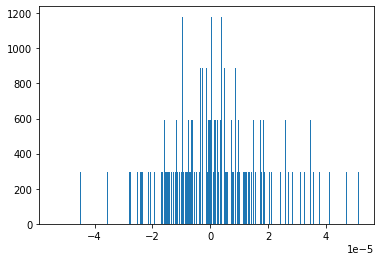

In [36]:
plt.hist(np_encoded_images_flattened, bins=500)

To find the shape of the estimated density function, we can generate a set of points equidistant from each other and estimate the kernel density at each point. The test points are given by the limits of the histogram that was generated above.

In [37]:
x_test = np.linspace(-5e-5, 5e-5, np_encoded_images_flattened.shape[0])[:, np.newaxis]

Testing different Bandwidth parameter values

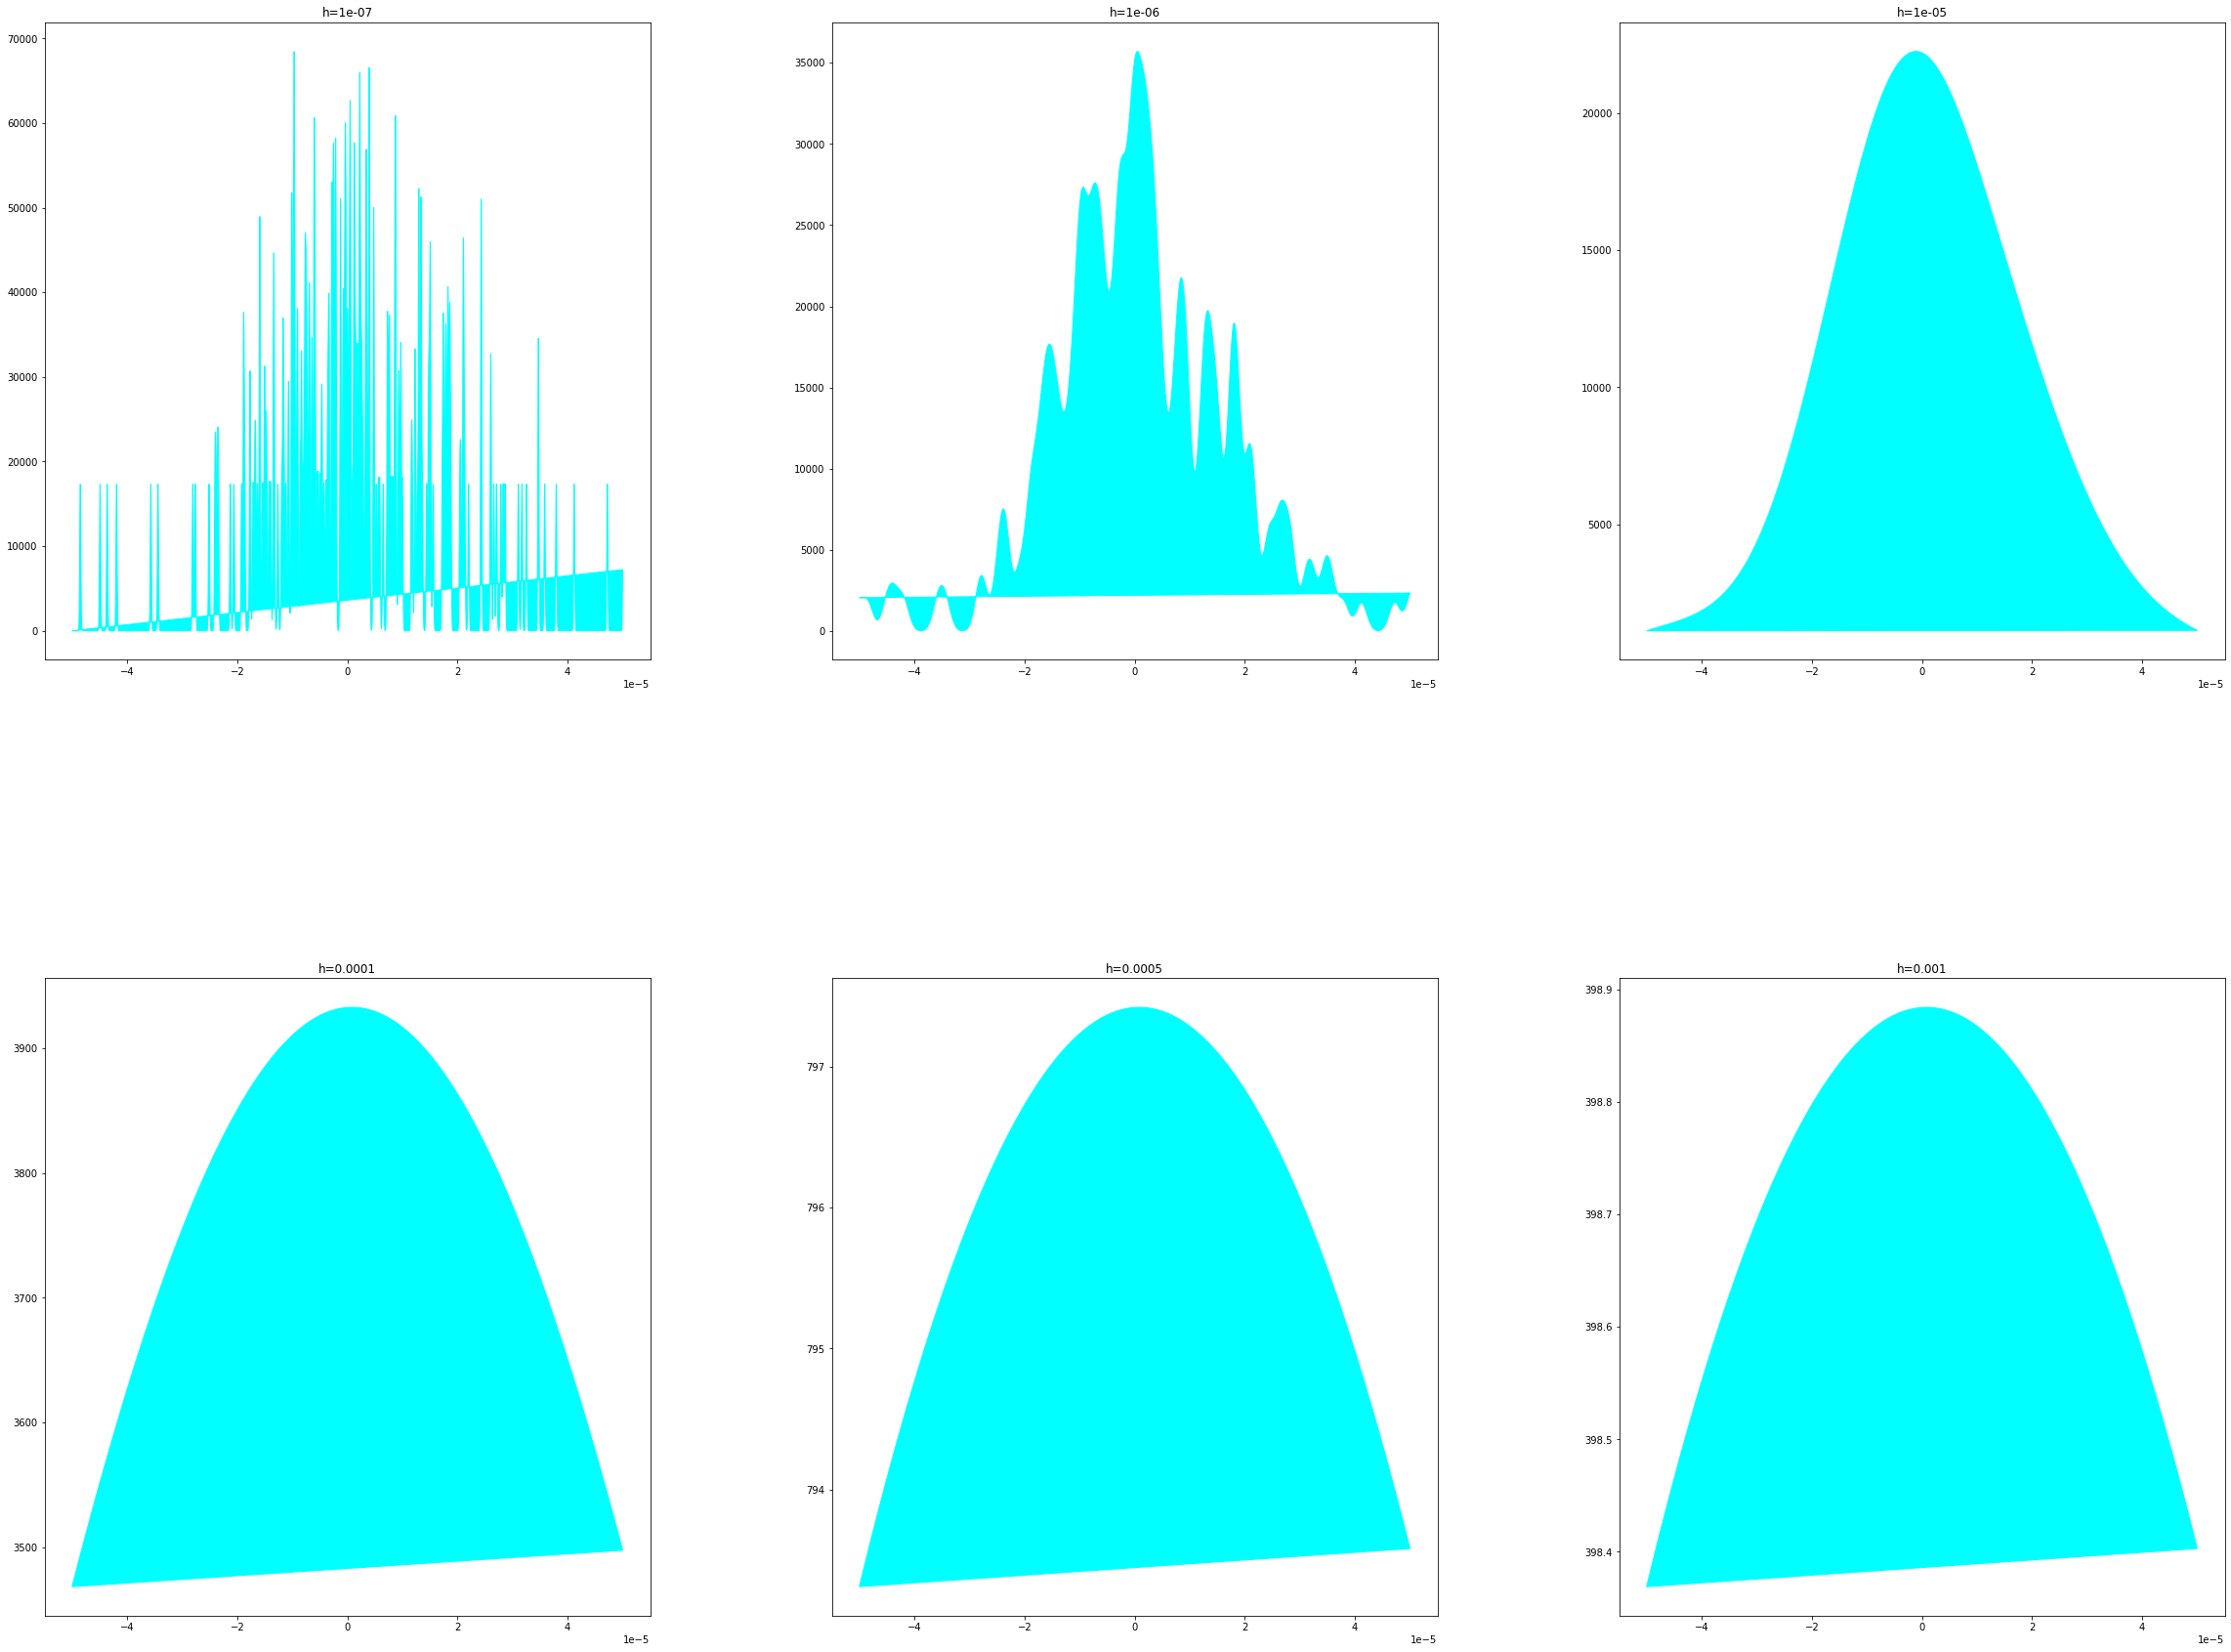

In [41]:
bandwidths = [0.0000001, 0.000001, 0.00001, 0.0001, 0.0005, 0.001]
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(40, 30))
plt_ind = np.arange(6) + 231

for b, ind in zip(bandwidths, plt_ind):
    kde_model = KernelDensity(kernel='gaussian', bandwidth=b)
    kde_model.fit(np_encoded_images_flattened)
    score = kde_model.score_samples(x_test)
    plt.subplot(ind)
    plt.fill(x_test, np.exp(score), c='cyan')
    plt.title("h="+str(b))

fig.subplots_adjust(hspace=0.5, wspace=.3)
plt.show()

From all the badwidth values tested, the one that correspond to h=0.05 seems to be most accurate one. 

In [42]:
from sklearn.model_selection import GridSearchCV
bandwidth_values = np.array([0.0000001, 0.000001, 0.00001, 0.0001, 0.0005, 0.001])
kde = KernelDensity(kernel='gaussian')
grid = GridSearchCV(kde, {'bandwidth': bandwidth_values})
grid.fit(np_encoded_images_flattened)

GridSearchCV(estimator=KernelDensity(),
             param_grid={'bandwidth': array([1.e-07, 1.e-06, 1.e-05, 1.e-04, 5.e-04, 1.e-03])})

In [43]:
best_bandwidth = grid.best_estimator_
print(best_bandwidth)

KernelDensity(bandwidth=1e-07)


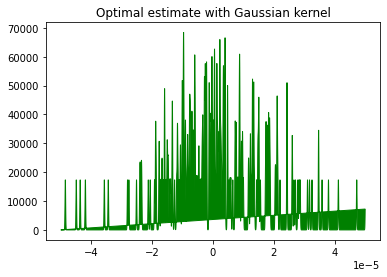

In [44]:
kde = grid.best_estimator_
log_dens = kde.score_samples(x_test)
plt.fill(x_test, np.exp(log_dens), c='green')
plt.title('Optimal estimate with Gaussian kernel')
plt.show()

In [38]:
kde = KernelDensity(kernel='gaussian', bandwidth=1e-07).fit(np_encoded_images_flattened)

In [39]:
log_density_vals = kde.score_samples(np_encoded_images_flattened)
print(log_density_vals)

[ 9.76107781 10.72094866  9.76402768 ... 10.24098    11.04607745
  9.76107781]


In [40]:
densitiy_vals = np.exp(log_density_vals)
print(densitiy_vals.shape)

(67850,)


(array([12095.,  1180.,  1770.,   590.,   295.,   590.,     0.,   590.,
          590.,   590.,  1475.,  1180.,   295.,   295.,   295.,     0.,
            0.,     0.,     0.,   885.,   885.,   590.,   590.,   295.,
            0.,  1180.,     0.,     0.,   295.,     0.,   295.,   885.,
          885.,   295.,  1180.,   295.,   590.,   885.,   295.,   590.,
         1770.,  1180.,   590.,   295.,  1475.,   295.,  1180.,  1180.,
         1180.,   590.,   295.,   295.,   295.,   590.,   295.,   295.,
          295.,     0.,     0.,   885.,   885.,   295.,     0.,   590.,
          590.,   590.,     0.,     0.,  1180.,     0.,   295.,   295.,
          590.,   590.,   885.,   885.,   885.,   295.,   295.,  1180.,
          295.,   590.,   590.,   885.,     0.,   590.,   590.,   590.,
          295.,     0.,   295.,     0.,   295.,   885.,   295.,   295.,
          295.,   295.,   295.,     0.,     0.,   295.,   295.,     0.,
            0.,     0.,   885.,   590.,   295.,   295.,     0., 

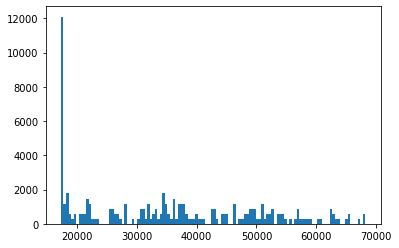

In [41]:
plt.hist(densitiy_vals, bins=120)

From the histogram shown above it can be seen that the density score values are too spread. Anyway, the average value is obtained from these density score values. 

From here, the mean and standard deviation of these values are computed

In [42]:
average_density = np.mean(densitiy_vals)
stdev_density = np.std(densitiy_vals)
print("The avg of the density values is: ", average_density)
print("The stdev_density of the density values is: ", stdev_density)

The avg of the density values is:  35339.374033527936
The stdev_density of the density values is:  14754.027453515706


# Function to check if an image contains anomalies

Based on the previously found score of the KDE samples, its average and its standard deviation values, it can be built a function that maps the KDE scores to a probability value of an image being considered as an anomaly or not.

If the a given KDE score is outside the range of the standard deviation sum and subtraction to the average values, then that KDE score has more than 50% chance to be considered as an anomaly image.

In [43]:
def ranges_mapper(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

In [44]:
def map_kde2prob_list(input_list):
    threshold_NOanomaly = average_density          # The mean of the density values corresponding to the non-anomaly images
    std_dev_NOanomaly = stdev_density            # The std deviation of the density values corresponding to the non-anomaly images

    prob_score_list = []

    for i in range (len(input_list)):
        score_NOanomaly = input_list[i] - threshold_NOanomaly

        perc_NOanomaly = ranges_mapper(abs(score_NOanomaly), 0, std_dev_NOanomaly, 0, 50)
        if perc_NOanomaly<0:
            perc_NOanomaly = 0
        if perc_NOanomaly>100:
            perc_NOanomaly = 100
        prob_score_list.append(perc_NOanomaly)
    return prob_score_list

In [45]:
def map_kde2prob(value):
    threshold_NOanomaly = average_density          # The mean of the density values corresponding to the non-anomaly images
    std_dev_NOanomaly = stdev_density            # The std deviation of the density values corresponding to the non-anomaly images

    score_NOanomaly = value - threshold_NOanomaly

    perc_NOanomaly = ranges_mapper(abs(score_NOanomaly), 0, std_dev_NOanomaly, 0, 50)
    if perc_NOanomaly<0:
        perc_NOanomaly = 0
    if perc_NOanomaly>100:
        perc_NOanomaly = 100
    
    prob_score = perc_NOanomaly
    return prob_score

In [46]:
print(map_kde2prob(average_density+stdev_density))

50.000000000000014


In [47]:
def computePred(kde_value):
    pred = 0
    prob_anomaly = map_kde2prob(kde_value)/100
    if prob_anomaly > 0.5:
        pred = 1
    return pred

In [48]:
print("The prob of the kde value of being anomaly image is: ", map_kde2prob(average_density+stdev_density))
print("Given the probability, it is actually predicted as:", computePred(average_density+stdev_density))

The prob of the kde value of being anomaly image is:  50.000000000000014
Given the probability, it is actually predicted as: 1


# Validating the performance of the model with reconstruction error directly

We will use the validation data set to find the best threshold value for predicting an image as anomaly or non-anomaly.

In [49]:
val_dir = '../../Images/june5Night/Validation'      #This is for the home laptop
# test_dir = '../../../Images/BottleStoodUp_atNight/Evaluation'      #This is for the home laptop
# test_dir = '../../../../BottleStoodUp_atNight/Evaluation'      #This is for the work laptop
transform_characteristics = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize(255),
                                                transforms.CenterCrop(224)])

dataset_val = datasets.ImageFolder(val_dir, transform=transform_characteristics)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=15, shuffle=True)
classes = ('non-anomaly','anomaly')

In [50]:
y_true = []
encoded_images = []

for i in range(len(dataset_val)):
    X = dataset_val[i]
    image_in_tensor = X[0]
    imgs_croped = transforms.functional.crop(image_in_tensor.cuda(), TOP_CROP_POS, LEFT_CROP_POS, 160, 160)
    image_in_tensor = imgs_croped[None, :].cuda()   # If using the GPU
    # image_in_tensor = image_in_tensor[None, :]   # If NO GPU
    ground_truth = X[1]

    with torch.no_grad():
        Y = model_encoder(image_in_tensor)  # should be same as X
    encoded_images.append(Y)
    y_true.append(ground_truth) # Save Truth
print("The ground truth labels are: ", y_true)
print("The encoded_images len is: ", len(encoded_images)) 



c:\Users\alexj\.conda\envs\tfm_3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


The ground truth labels are:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
The encoded_images len is:  30


In [51]:
np_encoded_images = []
for i in range (len(encoded_images)):
    # np_conversion = encoded_images[i].detach().numpy()        # If not using GPU
    np_conversion = encoded_images[i].cpu().detach().numpy()    # If using GPU
    np_encoded_images.append(np_conversion)
np_encoded_images = np.array(np_encoded_images)
print(np_encoded_images.shape)
np_encoded_images_vector = np.squeeze(np_encoded_images)
print(np_encoded_images_vector.shape)

(30, 1, 230)
(30, 230)


In [52]:
np_encoded_images_flattened = np_encoded_images_vector.flatten()
print(np_encoded_images_flattened.shape)

(6900,)


In [53]:
np_encoded_images_flattened = np_encoded_images_flattened[:, np.newaxis]
print(np_encoded_images_flattened.shape)

(6900, 1)


In [54]:
log_density_vals_validation = kde.score_samples(np_encoded_images_flattened)
print(log_density_vals_validation.shape)

(6900,)


In [55]:
density_validation = np.exp(log_density_vals_validation)
print(density_validation.shape)

(6900,)


In [56]:
print(density_validation)

[17345.31653919 45294.85195137 17396.55846112 ... 28028.58050132
 62697.53757049 17345.31653919]


At this point we have the density scores for all the features in the validation set. These values will be reshaped into (30,230) because the validation set consists of 30 images and each of them has a 230 features-vector.

In [57]:
reshaped_density_validation = density_validation.reshape(30,num_features)
print(reshaped_density_validation.shape)

(30, 230)


We compute the average of each of the image's feature vector so that, we have a representative value for each feature vector of each image.

In [58]:
density_avgs = np.mean(reshaped_density_validation, axis=1)
print(density_avgs.shape)

(30,)


In [59]:
print(density_avgs)

[35339.37425375 35339.37425375 35339.37425375 35339.37337528
 35339.37425296 35339.37425375 35339.37425375 35339.37425296
 35339.37411331 35339.37425296 35339.37411409 35339.37411409
 35339.37411331 35339.37411331 35339.37425375 35339.37425296
 35339.37411331 35339.37405958 35339.37338632 35339.37338632
 35339.37405615 35339.37331023 35339.37351623 35339.3733189
 35339.37405693 35339.37351544 35339.37351571 35339.37405615
 35339.37405642 35339.37403963]


These average values are shown in a histogram, to clearly see the sparsity of these values. From these values, 10 of them are expected to be separate from the others, because the validation data set consists of 10 anomaly images.

(array([ 2.,  0.,  0.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         5.,  0.,  0.,  6.,  0.,  0.,  0.,  0.,  0.,  0., 10.]),
 array([35339.37331023, 35339.3733291 , 35339.37334797, 35339.37336684,
        35339.37338571, 35339.37340458, 35339.37342345, 35339.37344232,
        35339.37346119, 35339.37348006, 35339.37349893, 35339.3735178 ,
        35339.37353668, 35339.37355555, 35339.37357442, 35339.37359329,
        35339.37361216, 35339.37363103, 35339.3736499 , 35339.37366877,
        35339.37368764, 35339.37370651, 35339.37372538, 35339.37374425,
        35339.37376312, 35339.37378199, 35339.37380086, 35339.37381973,
        35339.3738386 , 35339.37385747, 35339.37387634, 35339.37389521,
        35339.37391408, 35339.37393295, 35339.37395182, 35339.37397069,
        35339.37398956, 35339.37400843, 35339.3740273 , 35339.374046

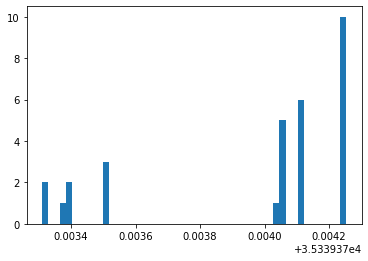

In [60]:
plt.hist(density_avgs, bins=50)

The histogram seen above, shows too much sparsity. 

Let's compute the ROC and AUC score out of directly the density scores obtained from the images of the validation data set.

In [61]:
from sklearn import metrics
print('AUC = ', metrics.roc_auc_score(y_true, density_avgs))

AUC =  0.12000000000000002


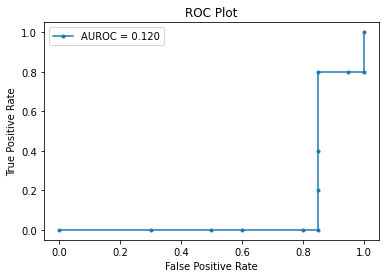

In [62]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, density_avgs)
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % metrics.roc_auc_score(y_true, density_avgs))
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [63]:
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

The fpr is:  [0.   0.3  0.5  0.6  0.8  0.85 0.85 0.85 0.85 0.95 1.   1.  ]
The tpr is:  [0.  0.  0.  0.  0.  0.  0.2 0.4 0.8 0.8 0.8 1. ]
The thresholds are:  [35340.37425375 35339.37425375 35339.37425296 35339.37411409
 35339.37411331 35339.37405958 35339.37405642 35339.37405615
 35339.37351544 35339.37338632 35339.37337528 35339.37331023]


The best threshold value for this is: 35339.37331, let's asses this.

In [64]:
def pred_label_onProb(probs_list, prob_threshold):
    pred_based_onProb = []
    for i in range (len(probs_list)):
        if probs_list[i] > prob_threshold:
            prediction = 1                          ## Stands for classifiaction of anomaly bottle
        else:
            prediction = 0
        pred_based_onProb.append(prediction)
    return pred_based_onProb

In [65]:
# from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, SpecificityAtSensitivity
from sklearn.metrics import confusion_matrix

In [66]:
best_threshold_approach1 = 35339.37331


In [67]:
conf_matrix = confusion_matrix(y_true, pred_label_onProb(density_avgs, best_threshold_approach1))
print(conf_matrix)
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)
print("Using the threshold = ", best_threshold_approach1)

[[ 0 20]
 [ 0 10]]
The FPR values are:  1.0
The TPR values are:  1.0
Using the threshold =  35339.37331


# Validating the performance of the model with the mapping of the reconstruction error to a probability value

In [68]:
probs_list = map_kde2prob_list(density_avgs)
print("The probability list is: ", probs_list)
print("The ground truth labels are: ", y_true)

The probability list is:  [7.462963799844409e-07, 7.462963799844409e-07, 7.462963799844409e-07, 2.2307558535452564e-06, 7.436506269706906e-07, 7.462963799844409e-07, 7.462963799844409e-07, 7.436506269706906e-07, 2.703600812985255e-07, 7.436506269706906e-07, 2.730058343122758e-07, 2.730058343122758e-07, 2.703600812985255e-07, 2.703600812985255e-07, 7.462963799844409e-07, 7.436506269706906e-07, 2.703600812985255e-07, 8.828909861674347e-08, 2.1933161059353e-06, 2.1933161059353e-06, 7.665754973828723e-08, 2.451181822051015e-06, 1.7530893112924456e-06, 2.421812632091744e-06, 7.930330275203756e-08, 1.7557348177308916e-06, 1.7548195795168713e-06, 7.665754973828723e-08, 7.7572812609838e-08, 2.068251459605444e-08]
The ground truth labels are:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [69]:
from sklearn import metrics
print('AUC = ', metrics.roc_auc_score(y_true, probs_list))

AUC =  0.45500000000000007


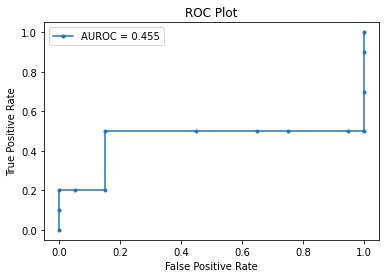

In [70]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, probs_list)
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % metrics.roc_auc_score(y_true, probs_list))
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [71]:
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

The fpr is:  [0.   0.   0.   0.05 0.15 0.15 0.45 0.65 0.75 0.95 1.   1.   1.   1.  ]
The tpr is:  [0.  0.1 0.2 0.2 0.2 0.5 0.5 0.5 0.5 0.5 0.5 0.7 0.9 1. ]
The thresholds are:  [1.00000245e+00 2.45118182e-06 2.42181263e-06 2.23075585e-06
 2.19331611e-06 1.75308931e-06 7.46296380e-07 7.43650627e-07
 2.73005834e-07 2.70360081e-07 8.82890986e-08 7.75728126e-08
 7.66575497e-08 2.06825146e-08]


In [72]:
best_threshold_approach2 = 2.06825146e-08

The best threshold in terms of FPR and TPR is 2.06825146e-08. Let's asses that.

In [73]:
conf_matrix = confusion_matrix(y_true, pred_label_onProb(probs_list, best_threshold_approach2))
print(conf_matrix)
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)
print("Using the threshold = ", best_threshold_approach2)

[[ 0 20]
 [ 1  9]]
The FPR values are:  1.0
The TPR values are:  0.9
Using the threshold =  2.06825146e-08


# Evaluating the model. With the threhsold value of the direct deinsity score

In [74]:
test_dir = '../../Images/june5Night/Evaluation'      #This is for the home laptop
# test_dir = '../../../Images/BottleStoodUp_atNight/Evaluation'      #This is for the home laptop
# test_dir = '../../../../BottleStoodUp_atNight/Evaluation'      #This is for the work laptop
transform_characteristics = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize(255),
                                                transforms.CenterCrop(224)])

dataset_test = datasets.ImageFolder(test_dir, transform=transform_characteristics)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=15, shuffle=True)
classes = ('non-anomaly','anomaly')

In [75]:
y_true = []
densityScore_lst = []

for i in range(len(dataset_test)):
    X = dataset_test[i]
    image_in_tensor = X[0]
    imgs_croped = transforms.functional.crop(image_in_tensor.cuda(), TOP_CROP_POS, LEFT_CROP_POS, 160, 160)
    image_in_tensor = imgs_croped[None, :].cuda()   # If using the GPU
    # image_in_tensor = image_in_tensor[None, :]   # If NO GPU
    ground_truth = X[1]

    with torch.no_grad():
        Y = model_encoder(image_in_tensor)  # should be same as X
    np_converted_encoded_img = Y.cpu().detach().numpy()
    # print(np_converted_encoded_img.shape)
    reshaped_arr = np.reshape(np_converted_encoded_img, (num_features, 1))
    # print(reshaped_arr.shape)
    log_density_score = kde.score_samples(reshaped_arr)
    density_score= np.exp(log_density_score)
    reshaped_density_score = density_score.reshape(1,num_features)
    # print(reshaped_density_score.shape)
    density_avg = np.mean(reshaped_density_score, axis=1)
    # print(density_avg.shape)
    # # print(density_score)
    densityScore_lst.append(density_avg)

    y_true.append(ground_truth) # Save Truth
print("The density score list is: ", densityScore_lst)
print("The ground truth labels are: ", y_true)

c:\Users\alexj\.conda\envs\tfm_3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
c:\Users\alexj\.conda\envs\tfm_3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to b

The density score list is:  [array([35339.37425296]), array([35339.37425296]), array([35339.37425375]), array([35339.37425296]), array([35339.37425296]), array([35339.37411409]), array([35339.37425269]), array([35339.37351493]), array([35339.37351544]), array([35339.37425348]), array([35339.37351544]), array([35339.37425375]), array([35339.37351493]), array([35339.37425296]), array([35339.37351493]), array([35339.37411331]), array([35339.37351466]), array([35339.37412435]), array([35339.37405931]), array([35339.37405931]), array([35339.37331023]), array([35339.37404853]), array([35339.3732353]), array([35339.37351544]), array([35339.37404904]), array([35339.37351623]), array([35339.37351544]), array([35339.37351571]), array([35339.37405642]), array([35339.37405615])]
The ground truth labels are:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [76]:
conf_matrix = confusion_matrix(y_true, pred_label_onProb(densityScore_lst, best_threshold_approach1))
print(conf_matrix)
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)
print("Using the threshold = ", best_threshold_approach1)

[[ 0 20]
 [ 1  9]]
The FPR values are:  1.0
The TPR values are:  0.9
Using the threshold =  35339.37331


In [77]:
y_pred = pred_label_onProb(densityScore_lst, best_threshold_approach1)
print("The groudn truth is: ", y_true)
print("The predicted label is: ", y_pred)

The groudn truth is:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
The predicted label is:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]


# Applying evaluation metrics to these results

## Computing the confusion matrix

In [78]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

In [79]:
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)

[[ 0 20]
 [ 1  9]]


Text(0.5, 15.0, 'Predicted label')

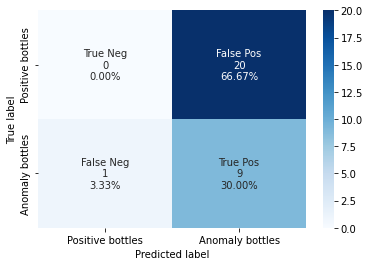

In [80]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]        #To print the group names as well 

labels = np.asarray(labels).reshape(2,2)
categories = ['Positive bottles', 'Anomaly bottles']
sn.heatmap(conf_matrix, annot=labels, fmt='', xticklabels=categories,yticklabels=categories, cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [81]:
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)

The FPR values are:  1.0
The TPR values are:  0.9


## Precision metric

Precision = True positives / (True positives + False positives).

Answers the question: Which proportion of positive predictions is actually right?

In [82]:
precision = _tp/(_tp+_fp)
print("The precision is: ", precision)


The precision is:  0.3103448275862069


## Recall metric

Recall = TruePositives / (TruePositives + FalseNegatives)

This metric is also called "sensitiviy" and TPR "True Positive Rate". It responds how good is the model at catching YESes?

In [83]:
recall = _tp/(_tp+_fn)
print("The recall is: ", recall)

The recall is:  0.9


## Specificity

Specificity = True negatives / (True negatives + false positives)

The specificity metric is the opposite as sensitivity, it tells us how good is the model at catching NOes. It measures the proportion of actual negatives that are correctly identified as such.

In [84]:
spec = _tn/(_tn+_fp)
print("The specificity is: ", spec)

The specificity is:  0.0


## Accuracy

Accuracy = (True negatives + True positives) / (True positives + True negatives + False positives + False negatives)

In [85]:
acc = (_tn+_tp)/(_tn+_tp +_fp + _fn)
print("The accuracy is: ", acc)

The accuracy is:  0.3


## The ROC curve

In [86]:
from sklearn.metrics import roc_curve, roc_auc_score


Rather than the prediction of each sample (0 or 1 values) we need the probability of the samples to be predicted as an anomaly image. Hence, we compute this probability

In [87]:
auc_score = roc_auc_score(y_true, densityScore_lst)
print('AUROC = %.3f' % (auc_score))
fpr, tpr, thresholds = roc_curve(y_true, densityScore_lst)
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

AUROC = 0.230
The fpr is:  [0.   0.1  0.15 0.4  0.6  0.7  0.7  0.8  0.95 1.   1.  ]
The tpr is:  [0.  0.  0.  0.  0.  0.  0.6 0.8 0.8 0.8 1. ]
The thresholds are:  [35340.37425375 35339.37425375 35339.37425348 35339.37425296
 35339.37411331 35339.37405931 35339.37351571 35339.37351544
 35339.37351493 35339.37351466 35339.3732353 ]


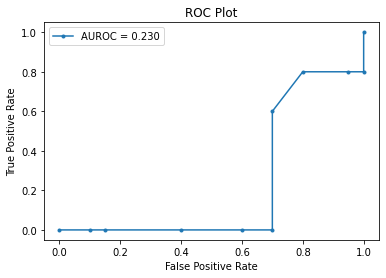

In [88]:
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % auc_score)
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

# Evaluating the model. With the threhsold value computed from a probability value upon the density scores

In [89]:
probs_list = map_kde2prob_list(densityScore_lst)
print("The probability list is: ", probs_list)
print("The ground truth labels are: ", y_true)

The probability list is:  [7.436506269706906e-07, 7.436506269706906e-07, 7.462963799844409e-07, 7.436506269706906e-07, 7.436506269706906e-07, 2.730058343122758e-07, 7.427353887566704e-07, 1.757465307873091e-06, 1.7557348177308916e-06, 7.453811171128901e-07, 1.7557348177308916e-06, 7.462963799844409e-07, 1.757465307873091e-06, 7.436506269706906e-07, 1.757465307873091e-06, 2.703600812985255e-07, 1.758380570744642e-06, 3.0779980425095164e-07, 8.737383574519269e-08, 8.737383574519269e-08, 2.451181822051015e-06, 5.084935100678687e-08, 2.7051089415181532e-06, 1.7557348177308916e-06, 5.257984114898642e-08, 1.7530893112924456e-06, 1.7557348177308916e-06, 1.7548195795168713e-06, 7.7572812609838e-08, 7.665754973828723e-08]
The ground truth labels are:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [90]:
conf_matrix = confusion_matrix(y_true, pred_label_onProb(probs_list, best_threshold_approach2))
print(conf_matrix)
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)
print("Using the threshold = ", best_threshold_approach2)

[[ 0 20]
 [ 0 10]]
The FPR values are:  1.0
The TPR values are:  1.0
Using the threshold =  2.06825146e-08


In [91]:
y_pred = pred_label_onProb(probs_list, best_threshold_approach2)
print("The groudn truth is: ", y_true)
print("The predicted label is: ", y_pred)

The groudn truth is:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
The predicted label is:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


# Applying evaluation metrics to these results

## Computing the confusion matrix

In [86]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

In [87]:
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)

[[ 9 11]
 [ 4  6]]


Text(0.5, 15.0, 'Predicted label')

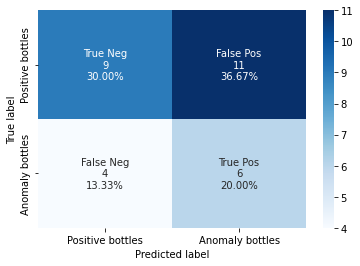

In [88]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]        #To print the group names as well 

labels = np.asarray(labels).reshape(2,2)
categories = ['Positive bottles', 'Anomaly bottles']
sn.heatmap(conf_matrix, annot=labels, fmt='', xticklabels=categories,yticklabels=categories, cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [89]:
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)

The FPR values are:  0.55
The TPR values are:  0.6


## Precision metric

Precision = True positives / (True positives + False positives).

Answers the question: Which proportion of positive predictions is actually right?

In [90]:
precision = _tp/(_tp+_fp)
print("The precision is: ", precision)


The precision is:  0.35294117647058826


## Recall metric

Recall = TruePositives / (TruePositives + FalseNegatives)

This metric is also called "sensitiviy" and TPR "True Positive Rate". It responds how good is the model at catching YESes?

In [91]:
recall = _tp/(_tp+_fn)
print("The recall is: ", recall)

The recall is:  0.6


## Specificity

Specificity = True negatives / (True negatives + false positives)

The specificity metric is the opposite as sensitivity, it tells us how good is the model at catching NOes. It measures the proportion of actual negatives that are correctly identified as such.

In [92]:
spec = _tn/(_tn+_fp)
print("The specificity is: ", spec)

The specificity is:  0.45


## Accuracy

Accuracy = (True negatives + True positives) / (True positives + True negatives + False positives + False negatives)

In [93]:
acc = (_tn+_tp)/(_tn+_tp +_fp + _fn)
print("The accuracy is: ", acc)

The accuracy is:  0.5


## The ROC curve

In [94]:
from sklearn.metrics import roc_curve, roc_auc_score


Rather than the prediction of each sample (0 or 1 values) we need the probability of the samples to be predicted as an anomaly image. Hence, we compute this probability

In [95]:
auc_score = roc_auc_score(y_true, probs_list)
print('AUROC = %.3f' % (auc_score))
fpr, tpr, thresholds = roc_curve(y_true, probs_list)
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

AUROC = 0.520
The fpr is:  [0.   0.05 0.2  0.2  0.45 0.45 0.55 0.55 0.6  0.6  0.7  0.7  0.75 0.75
 1.  ]
The tpr is:  [0.  0.  0.  0.3 0.3 0.5 0.5 0.6 0.6 0.7 0.7 0.9 0.9 1.  1. ]
The thresholds are:  [68.06428708 67.06428708 56.08502199 18.41825858 12.90501529 11.51586264
  9.24942805  8.92214625  7.8470203   7.76743518  5.95307106  4.63518069
  4.51409676  3.2546196   0.24404835]


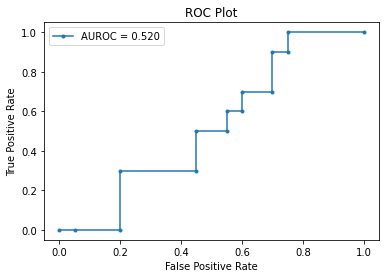

In [96]:
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % auc_score)
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()